<h1> Implementing a CNN in a TensorFlow</h1>


In [5]:
import warnings
warnings.filterwarnings('ignore')  

import numpy as np
import tensorflow as tf
# from tensorflow.compat.v1.examples.tutorials.mnist import input_data
# tf.logging.set_verbosity(tf.logging.ERROR)
tf.compat.v1.disable_eager_execution()
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_datasets
%matplotlib inline

In [6]:
mnist_data, info = tensorflow_datasets.load("mnist", with_info=True, as_supervised=True)
train=(mnist_data["train"])
# train_df = tensorflow_datasets.as_dataframe(mnist_data["train"],info)

In [7]:
def initialize_weights(shape):
 return tf.Variable(tf.compat.v1.truncated_normal(shape, stddev=0.1))

def initialize_bias(shape):
 return tf.Variable(tf.compat.v1.constant(0.1, shape=shape))

def convolution(x, W):
 return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pooling(x):
 return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def flatten_image(image, label):
  image = tf.reshape(image, [-1])  # Flatten the image
  return image, label

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0 # Normalize the images to [0, 1]
    image = tf.reshape(image, [-1])  # Flatten the image
    label = tf.one_hot(label, depth=10)  # One-hot encode the labels
    return image, label

X_ = tf.compat.v1.placeholder(tf.float32, [None, 784])
X = tf.reshape(X_, [-1, 28, 28, 1])
y = tf.compat.v1.placeholder(tf.float32, [None, 10])




In [8]:
W1 = initialize_weights([5,5,1,32])
b1 = initialize_bias([32])
conv1 = tf.compat.v1.nn.relu(convolution(X, W1) + b1)
pool1 = max_pooling(conv1)

W2 = initialize_weights([5,5,32,64])
b2 = initialize_bias([64])
conv2 = tf.compat.v1.nn.relu(convolution(pool1, W2) + b2)
pool2 = max_pooling(conv2)

flattened = tf.reshape(pool2, [-1, 7*7*64])
W_fc = initialize_weights([7*7*64, 1024])
b_fc = initialize_bias([1024])
fc_output = tf.compat.v1.nn.relu(tf.compat.v1.matmul(flattened, W_fc) + b_fc)

W_out = initialize_weights([1024, 10])
b_out = initialize_bias([10])
YHat = tf.compat.v1.nn.softmax(tf.compat.v1.matmul(fc_output, W_out) + b_out)

In [9]:
cross_entropy = -tf.compat.v1.reduce_sum(y*tf.compat.v1.log(YHat))
optimizer = tf.compat.v1.train.AdamOptimizer(1e-4).minimize(cross_entropy)

predicted_digit = tf.argmax(YHat, 1)
actual_digit = tf.argmax(y, 1)

correct_pred = tf.equal(predicted_digit,actual_digit)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [10]:

# hyperparameters
n_epochs =5
batch_size = 200
num_iterations = 60_000 // batch_size
session = tf.compat.v1.Session()
session.run(tf.compat.v1.global_variables_initializer())

In [11]:
train_batched = train.map(preprocess).batch(batch_size)

for epoch in range(n_epochs):

    # Create an iterator and initialize it
    iterator = tf.compat.v1.data.make_initializable_iterator(train_batched)
    next_batch = iterator.get_next()
    session.run(iterator.initializer)

    for i in range(num_iterations):
        # Fetch the next batch
        X_batch, y_batch = session.run(next_batch)

        # Train the network
        _, batch_loss, batch_accuracy = session.run(
            [optimizer, cross_entropy, accuracy],
            feed_dict={X_: X_batch, y: y_batch})

        # Print updates every 10 iterations
        if i % 100 == 0:
            print(f"Epoch: {epoch}, Iteration: {i}, Loss: {batch_loss}, Accuracy: {batch_accuracy}")

Epoch: 0, Iteration: 0, Loss: 1031.868408203125, Accuracy: 0.054999999701976776
Epoch: 0, Iteration: 100, Loss: 60.849952697753906, Accuracy: 0.9350000023841858
Epoch: 0, Iteration: 200, Loss: 52.712860107421875, Accuracy: 0.9100000262260437
Epoch: 1, Iteration: 0, Loss: 28.795434951782227, Accuracy: 0.9649999737739563
Epoch: 1, Iteration: 100, Loss: 31.73971176147461, Accuracy: 0.949999988079071
Epoch: 1, Iteration: 200, Loss: 29.020645141601562, Accuracy: 0.9549999833106995
Epoch: 2, Iteration: 0, Loss: 18.195833206176758, Accuracy: 0.9700000286102295
Epoch: 2, Iteration: 100, Loss: 21.854686737060547, Accuracy: 0.9599999785423279
Epoch: 2, Iteration: 200, Loss: 19.700437545776367, Accuracy: 0.9750000238418579
Epoch: 3, Iteration: 0, Loss: 13.878240585327148, Accuracy: 0.9800000190734863
Epoch: 3, Iteration: 100, Loss: 15.995513916015625, Accuracy: 0.9700000286102295
Epoch: 3, Iteration: 200, Loss: 15.023185729980469, Accuracy: 0.9750000238418579
Epoch: 4, Iteration: 0, Loss: 11.8365

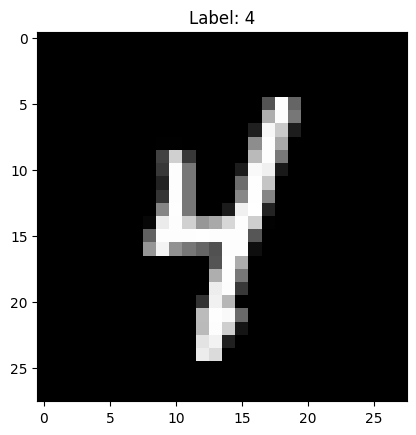

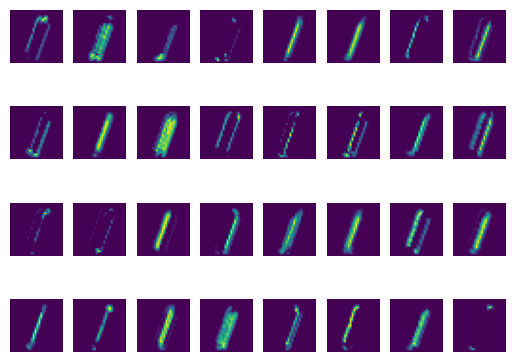

In [16]:
# Create an iterator for the dataset
ds_train_1_batched = train.batch(1)
iterator = tf.compat.v1.data.make_one_shot_iterator(ds_train_1_batched)
image, label = iterator.get_next()


image_val, label_val = session.run([image, label])
# Reshape and display the image using matplotlib
plt.imshow(image_val[0, :, :, 0], cmap='gray')  # MNIST images are grayscale
plt.title(f"Label: {label_val[0]}")
plt.show()

flatened_image, label = flatten_image(image, label)
reshaped_image = tf.reshape(flatened_image, [1, 784])
image_val, label_val = session.run([reshaped_image, label])

feature_map = session.run([conv1], feed_dict={X_: image_val})[0]


for i in range(32):
  feature = feature_map[:,:,:,i].reshape([28, 28])
  plt.subplot(4,8, i + 1)
  plt.imshow(feature)
  plt.axis('off')
plt.show()

<h1> Capsule Network</h1>

In [20]:
def squash(sj):
 sj_norm = tf.reduce_sum(tf.square(sj), -2, keepdims=True)
 scalar_factor = sj_norm / (1 + sj_norm) / tf.sqrt(sj_norm + 1e-6)
 vj = scalar_factor * sj 
 return vj

<h3>Dynamic Routing</h3>


In [30]:
def dynamic_routing(ui, bij, num_routing=10):
  wij = tf.compat.v1.get_variable('Weight', shape=(1, 1152, 160, 8, 1), dtype=tf.float32,
                        initializer=tf.random_normal_initializer(0.01))
  biases = tf.compat.v1.get_variable('bias', shape=(1, 1, 10, 16, 1))
  ui = tf.tile(ui, [1, 1, 160, 1, 1])
  u_hat = tf.reduce_sum(wij * ui, axis=3, keepdims=True)
  u_hat = tf.reshape(u_hat, shape=[-1, 1152, 10, 16, 1])
  u_hat_stopped = tf.stop_gradient(u_hat, name='stop_gradient')

  for r in range(num_routing):
    with tf.compat.v1.variable_scope('iter_' + str(r)):
      #step 1
      cij = tf.nn.softmax(bij, axis=2)
      #step 2
      if r == num_routing - 1:
        sj = tf.multiply(cij, u_hat)
        sj = tf.reduce_sum(sj, axis=1, keepdims=True) + biases
        vj = squash(sj)
      elif r < num_routing - 1:
        sj = tf.multiply(cij, u_hat_stopped)
        sj = tf.reduce_sum(sj, axis=1, keepdims=True) + biases
        vj = squash(sj)
        vj_tiled = tf.tile(vj, [1, 1152, 1, 1, 1])
        coupling_coeff = tf.reduce_sum(u_hat_stopped * vj_tiled, axis=3,
        keepdims=True)
        #step 3
        bij += coupling_coeff
  return vj

<h3>Computing primary and digit capsules</h3>

In [32]:
# for compatability with tf version 1
import tensorflow as tf
def conv2d(inputs, num_outputs, kernel_size, padding='VALID', activation=tf.nn.relu, scope=None, strides=[1,1,1,1]):
    with tf.compat.v1.variable_scope(scope, default_name='conv2d'):
        # Get the input channels
        input_channels = inputs.get_shape()[-1]
        # Define kernel shape
        kernel_shape = [kernel_size, kernel_size, int(input_channels), num_outputs]
        # Initialize weights (Glorot/Xavier initializer)
        weights = tf.compat.v1.get_variable(
            'weights', shape=kernel_shape, initializer=tf.compat.v1.glorot_uniform_initializer())
        # Initialize biases
        biases = tf.compat.v1.get_variable(
            'biases', shape=[num_outputs], initializer=tf.compat.v1.zeros_initializer())
        # Perform convolution
        conv = tf.nn.conv2d(inputs, weights, strides=strides, padding=padding)
        # Add bias
        conv = tf.nn.bias_add(conv, biases)
        # Apply activation function
        if activation:
            conv = activation(conv)
        return conv


graph = tf.Graph()
with graph.as_default() as g:
  x = tf.compat.v1.placeholder(tf.float32, [200, 784])
  y = tf.compat.v1.placeholder(tf.float32, [batch_size,10])
  x_image = tf.reshape(x, [-1,28,28,1])

  with tf.name_scope('convolutional_input'):
    input_data = conv2d(inputs=x_image, num_outputs=256,
                                          kernel_size=9, padding='VALID', activation=None, scope="conv1")
  capsules = []
  for i in range(8):
    with tf.name_scope('capsules_' + str(i)):
      #convolution operation
      output = conv2d(inputs=input_data, num_outputs=32,kernel_size=9,
                      strides=2, padding='VALID', activation=None, scope=f"conv2-{i}")
      #reshape the output
      output = tf.reshape(output, [batch_size, -1, 1, 1])
      #store the output which is capsule in the capsules list
      capsules.append(output)

  primary_capsule = tf.concat(capsules, axis=2)
  primary_capsule = squash(primary_capsule)

  with tf.name_scope('dynamic_routing'):
    #reshape the primary capsule
    outputs = tf.reshape(primary_capsule, shape=(batch_size, -1, 1,
                                                 primary_capsule.shape[-2], 1))
    #initialize bij with 0s
    bij = tf.constant(np.zeros([1, primary_capsule.shape[1], 10, 1, 1],
                               dtype=np.float32))
    #compute the digit capsules using dynamic routing algorithm which takes
    #the reshaped primary capsules and bij as inputs and returns the activity vector
    digit_capsules = dynamic_routing(outputs, bij)

  digit_capsules = tf.squeeze(digit_capsules, axis=1)

<h3>Masking Digit Capsule</h3>


In [34]:
with graph.as_default() as g:
  with tf.compat.v1.variable_scope('Masking'):
    #select the activity vector of given input image using the actual label y
    # and mask out others
    masked_v = tf.multiply(tf.squeeze(digit_capsules), tf.reshape(y, (-1, 10, 1)))
    

<h3> Define the Decoder</h3>


In [41]:
# for compatability with tensorflow v1
def dense_layer(inputs, num_outputs, activation_fn=None, scope=None):
    with tf.compat.v1.variable_scope(scope, default_name='dense_layer'):
        input_dim = inputs.get_shape()[-1]
        weights = tf.compat.v1.get_variable(
            'weights', shape=[input_dim, num_outputs], initializer=tf.compat.v1.glorot_uniform_initializer())
        biases = tf.compat.v1.get_variable(
            'biases', shape=[num_outputs], initializer=tf.zeros_initializer())
        outputs = tf.matmul(inputs, weights) + biases
        if activation_fn:
            outputs = activation_fn(outputs)
        return outputs
    
with graph.as_default() as g:
  with tf.name_scope('Decoder'):
    #masked digit capsule
    v_j = tf.reshape(masked_v, shape=(batch_size, -1))
    #first fully connected layer
    fc1 = dense_layer(v_j, num_outputs=512, scope="fc1")
    #second fully connected layer
    fc2 = dense_layer(fc1, num_outputs=1024, scope="fc2")
    #reconstructed image
    reconstructed_image = dense_layer(fc2, num_outputs=784, activation_fn=tf.sigmoid)

<h3>Accuracy and Loss</h3>

In [50]:
with graph.as_default() as g:
  with tf.compat.v1.variable_scope('accuracy'):
    v_length = tf.sqrt(tf.reduce_sum(tf.square(digit_capsules), axis=2, keepdims=True) + 1e-6)

    softmax_v = tf.nn.softmax(v_length, axis=1)

    argmax_idx = tf.compat.v1.to_int32(tf.argmax(softmax_v, axis=1))
    predicted_digit = tf.reshape(argmax_idx, shape=(batch_size, ))

    actual_digit = tf.compat.v1.to_int32(tf.argmax(y, axis=1))

    correct_pred = tf.equal(predicted_digit,actual_digit)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    
    
# Marginal Loss
with graph.as_default() as g:
  max_left = tf.square(tf.maximum(0.,0.9 - v_length))
  max_right = tf.square(tf.maximum(0., v_length - 0.1))

  T_k = y
  lambda_ = 0.5
  L_k = T_k * max_left + lambda_ * (1 - T_k) * max_right

  margin_loss = tf.reduce_mean(tf.reduce_sum(L_k, axis=1))

# Reconstruction Loss
with graph.as_default() as g:
  original_image = tf.reshape(x, shape=(batch_size, -1))
  squared = tf.square(reconstructed_image - original_image)
  reconstruction_loss = tf.reduce_mean(squared)
  
  
#  Total Loss
with graph.as_default() as g:
  alpha = 0.0005
  total_loss = margin_loss + alpha * reconstruction_loss

  optimizer = tf.compat.v1.train.AdamOptimizer(0.0001)
  train_op = optimizer.minimize(total_loss)


In [63]:
# hyperparameters
num_epochs =5
batch_size = 200
num_steps = 60_000 // batch_size
session = tf.compat.v1.Session()
session.run(tf.compat.v1.global_variables_initializer())

In [ ]:
with graph.as_default() as g:

  (ds_train, ds_test), ds_info = tensorflow_datasets.load(
      'mnist',
      split=['train', 'test'],
      shuffle_files=True,
      as_supervised=True,
      with_info=True,
  )

  ds_train_batched = ds_train.map(preprocess).batch(batch_size)

  with tf.compat.v1.Session(graph=graph) as sess:
    init_op = tf.compat.v1.global_variables_initializer()
    sess.run(init_op)

    for epoch in range(num_epochs):
      iterator = tf.compat.v1.data.make_initializable_iterator(ds_train_batched)
      next_batch = iterator.get_next()

      sess.run(iterator.initializer)

      for iteration in range(num_steps):
        #select some batch of data points according to the batch size (100)
        X_batch, y_batch = sess.run(next_batch)

        feed_dict = {x : X_batch, y : y_batch}
        _, loss, acc = sess.run([train_op, total_loss, accuracy], feed_dict=feed_dict)

        if iteration%100 == 0:
          print('Epoch: {}, iteration:{}, Loss:{} Accuracy:{}'.format(epoch,iteration,loss,acc))


Epoch: 0, iteration:0, Loss:0.5749418139457703 Accuracy:0.05999999865889549
